Проанализировать данные по выживаемости. Обучить модель предсказания выживет ли человек или нет (ключевая переменная) (различные варианты визуализации можно посмотреть здесь https://www.kaggle.com/competitions/titanic/code?competitionId=3136&sortBy=scoreDescending&language=Python).
Определить наиболее значимые переменные которые влияют на выживаемость. 
Визуализировать дерево решений. 
Написать вывод. 
Не копировать бездумно чужие работы. 


Ответить на вопросы (обоснованно).

1. Как влияет размер семьи  на вероятность выживаемости (одинокие выживают чаще или нет?, люди у которых большая семья (больше 4) выживают чаще или нет).
2. Как влияет пол/возраст/номер палубы. 

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.pipeline import Pipeline
import re

In [66]:
# Загрузка датасетов
train = pd.read_csv('titanic_train.csv')
test = pd.read_csv('titanic_test.csv')

In [67]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [68]:
test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [69]:
# Удаляем имена
del train['Name']
del test['Name']

In [70]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [71]:
# Преобразуем пол в булевую переменную. 1 - мужчина, 0 - женщина.
def convert_to_boolean(df, column):
    """
    Преобразует значения столбца 'male'/'female' в булевые (True/False).
    """
    df[column] = df[column].str.lower().map({'male': 1, 'female': 0})
    return df

convert_to_boolean(train, 'Sex')
convert_to_boolean(test, 'Sex')

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,1,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,0,47.0,1,0,363272,7.0000,NaN,S
2,894,2,1,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,1,27.0,0,0,315154,8.6625,NaN,S
4,896,3,0,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...
413,1305,3,1,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,0,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,1,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,1,NaN,0,0,359309,8.0500,NaN,S


In [72]:
# Рассчитываем размер семьи
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1  
test['FamilySize'] = test['SibSp'] + test['Parch'] + 1 

In [73]:
train

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
0,1,0,3,1,22.0,1,0,A/5 21171,7.2500,NaN,S,2
1,2,1,1,0,38.0,1,0,PC 17599,71.2833,C85,C,2
2,3,1,3,0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,0,35.0,1,0,113803,53.1000,C123,S,2
4,5,0,3,1,35.0,0,0,373450,8.0500,NaN,S,1
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,1,27.0,0,0,211536,13.0000,NaN,S,1
887,888,1,1,0,19.0,0,0,112053,30.0000,B42,S,1
888,889,0,3,0,NaN,1,2,W./C. 6607,23.4500,NaN,S,4
889,890,1,1,1,26.0,0,0,111369,30.0000,C148,C,1


In [74]:
# Извлекаем индексы палубы
import re
def process_cabin_column(df, cabin_col='Cabin', deck_col='Deck'):
    """
    Преобразует столбец 'Cabin', оставляя только цифры, а буквы (палубу) переносит в отдельный столбец.
    
    Параметры:
        df: pd.DataFrame
            Исходный датафрейм.
        cabin_col: str, optional
            Имя столбца с номерами кают (по умолчанию 'Cabin').
        deck_col: str, optional
            Имя нового столбца для палуб (по умолчанию 'Deck').
    """
     # Извлекаем палубу (первый символ строки)
    df[deck_col] = df[cabin_col].str[0].where(df[cabin_col].notna(), None)
    
    # Оставляем только цифры в столбце Cabin и преобразуем их в int
    df[cabin_col] = df[cabin_col].apply(
        lambda x: int(''.join(re.findall(r'\d+', x))) if pd.notnull(x) and re.search(r'\d+', x) else None
    )
    
process_cabin_column(train)
process_cabin_column(test)

In [75]:
train

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Deck
0,1,0,3,1,22.0,1,0,A/5 21171,7.2500,NaN,S,2,None
1,2,1,1,0,38.0,1,0,PC 17599,71.2833,85.0,C,2,C
2,3,1,3,0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,None
3,4,1,1,0,35.0,1,0,113803,53.1000,123.0,S,2,C
4,5,0,3,1,35.0,0,0,373450,8.0500,NaN,S,1,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,1,27.0,0,0,211536,13.0000,NaN,S,1,None
887,888,1,1,0,19.0,0,0,112053,30.0000,42.0,S,1,B
888,889,0,3,0,NaN,1,2,W./C. 6607,23.4500,NaN,S,4,None
889,890,1,1,1,26.0,0,0,111369,30.0000,148.0,C,1,C


In [76]:
# Из номера билета удаляем буквы и символы, оставляем только номер
import re

def remove_letters_and_symbols(df, column):
    """
    Удаляет все буквы и символы, оставляя только цифры в указанном столбце.
    """
    df[column] = df[column].astype(str).apply(lambda x: re.sub(r'\D', '', x))
    df[column] = pd.to_numeric(df[column], errors='coerce')  # Преобразование в числовой тип
    return df

remove_letters_and_symbols(train, 'Ticket')
remove_letters_and_symbols(test, 'Ticket')

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Deck
0,892,3,1,34.5,0,0,330911,7.8292,NaN,Q,1,None
1,893,3,0,47.0,1,0,363272,7.0000,NaN,S,2,None
2,894,2,1,62.0,0,0,240276,9.6875,NaN,Q,1,None
3,895,3,1,27.0,0,0,315154,8.6625,NaN,S,1,None
4,896,3,0,22.0,1,1,3101298,12.2875,NaN,S,3,None
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,1,NaN,0,0,53236,8.0500,NaN,S,1,None
414,1306,1,0,39.0,0,0,17758,108.9000,105.0,C,1,C
415,1307,3,1,38.5,0,0,3101262,7.2500,NaN,S,1,None
416,1308,3,1,NaN,0,0,359309,8.0500,NaN,S,1,None


In [77]:
train

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Deck
0,1,0,3,1,22.0,1,0,521171.0,7.2500,NaN,S,2,None
1,2,1,1,0,38.0,1,0,17599.0,71.2833,85.0,C,2,C
2,3,1,3,0,26.0,0,0,23101282.0,7.9250,NaN,S,1,None
3,4,1,1,0,35.0,1,0,113803.0,53.1000,123.0,S,2,C
4,5,0,3,1,35.0,0,0,373450.0,8.0500,NaN,S,1,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,1,27.0,0,0,211536.0,13.0000,NaN,S,1,None
887,888,1,1,0,19.0,0,0,112053.0,30.0000,42.0,S,1,B
888,889,0,3,0,NaN,1,2,6607.0,23.4500,NaN,S,4,None
889,890,1,1,1,26.0,0,0,111369.0,30.0000,148.0,C,1,C


In [78]:
print(test['Ticket'].value_counts())

Ticket
17608     5
113503    4
2343      4
16966     3
220845    3
         ..
2621      1
4133      1
113780    1
369943    1
2668      1
Name: count, Length: 362, dtype: int64


In [79]:
missing_counts = train.isna().sum()
result = pd.DataFrame({'Column': missing_counts.index, 'MissingCount': missing_counts.values})

In [80]:
result

,Column,MissingCount
0,PassengerId,0
1,Survived,0
2,Pclass,0
3,Sex,0
4,Age,177
5,SibSp,0
6,Parch,0
7,Ticket,4
8,Fare,0
9,Cabin,691


В колонках Age, Cabin и Deck много пропусков, но их можно не удалять, так как будем строить дерево решений.

In [81]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_encode_column(df, column):
    """
    Кодирует указанный столбец с помощью OneHotEncoder и возвращает новый DataFrame.
    """
    encoder = OneHotEncoder(sparse_output=False)  # sparse=False для получения плотного массива
    encoded_data = encoder.fit_transform(df[[column]])
    encoded_columns = [f"{column}_{category}" for category in encoder.categories_[0]]
    
    encoded_df = pd.DataFrame(encoded_data, columns=encoded_columns, index=df.index)
    df = pd.concat([df, encoded_df], axis=1)  # Добавление закодированных столбцов к исходному DataFrame
    df.drop(column, axis=1, inplace=True)  # Удаление исходного столбца
    return df

df_train = one_hot_encode_column(train, 'Embarked')
df_train = one_hot_encode_column(df_train, 'Deck')
df_test = one_hot_encode_column(test, 'Embarked')
df_test = one_hot_encode_column(df_test, 'Deck')

In [82]:
df_train

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Embarked_nan,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_None
0,1,0,3,1,22.0,1,0,521171.0,7.2500,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2,1,1,0,38.0,1,0,17599.0,71.2833,85.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1,3,0,26.0,0,0,23101282.0,7.9250,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,4,1,1,0,35.0,1,0,113803.0,53.1000,123.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0,3,1,35.0,0,0,373450.0,8.0500,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,1,27.0,0,0,211536.0,13.0000,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
887,888,1,1,0,19.0,0,0,112053.0,30.0000,42.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
888,889,0,3,0,NaN,1,2,6607.0,23.4500,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
889,890,1,1,1,26.0,0,0,111369.0,30.0000,148.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [83]:
df_test

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,FamilySize,...,Embarked_Q,Embarked_S,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_None
0,892,3,1,34.5,0,0,330911,7.8292,NaN,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,893,3,0,47.0,1,0,363272,7.0000,NaN,2,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,894,2,1,62.0,0,0,240276,9.6875,NaN,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,895,3,1,27.0,0,0,315154,8.6625,NaN,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,896,3,0,22.0,1,1,3101298,12.2875,NaN,3,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,1,NaN,0,0,53236,8.0500,NaN,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
414,1306,1,0,39.0,0,0,17758,108.9000,105.0,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
415,1307,3,1,38.5,0,0,3101262,7.2500,NaN,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
416,1308,3,1,NaN,0,0,359309,8.0500,NaN,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [84]:
# Удалим Embarked_nan, так как там только 2 значения None
del df_train['Embarked_nan']

In [85]:
# Удалим Deck_T, так как там только 1 значение "1"
del df_train['Deck_T']

In [86]:
df_train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Sex              int64
Age            float64
SibSp            int64
Parch            int64
Ticket         float64
Fare           float64
Cabin          float64
FamilySize       int64
Embarked_C     float64
Embarked_Q     float64
Embarked_S     float64
Deck_A         float64
Deck_B         float64
Deck_C         float64
Deck_D         float64
Deck_E         float64
Deck_F         float64
Deck_G         float64
Deck_None      float64
dtype: object

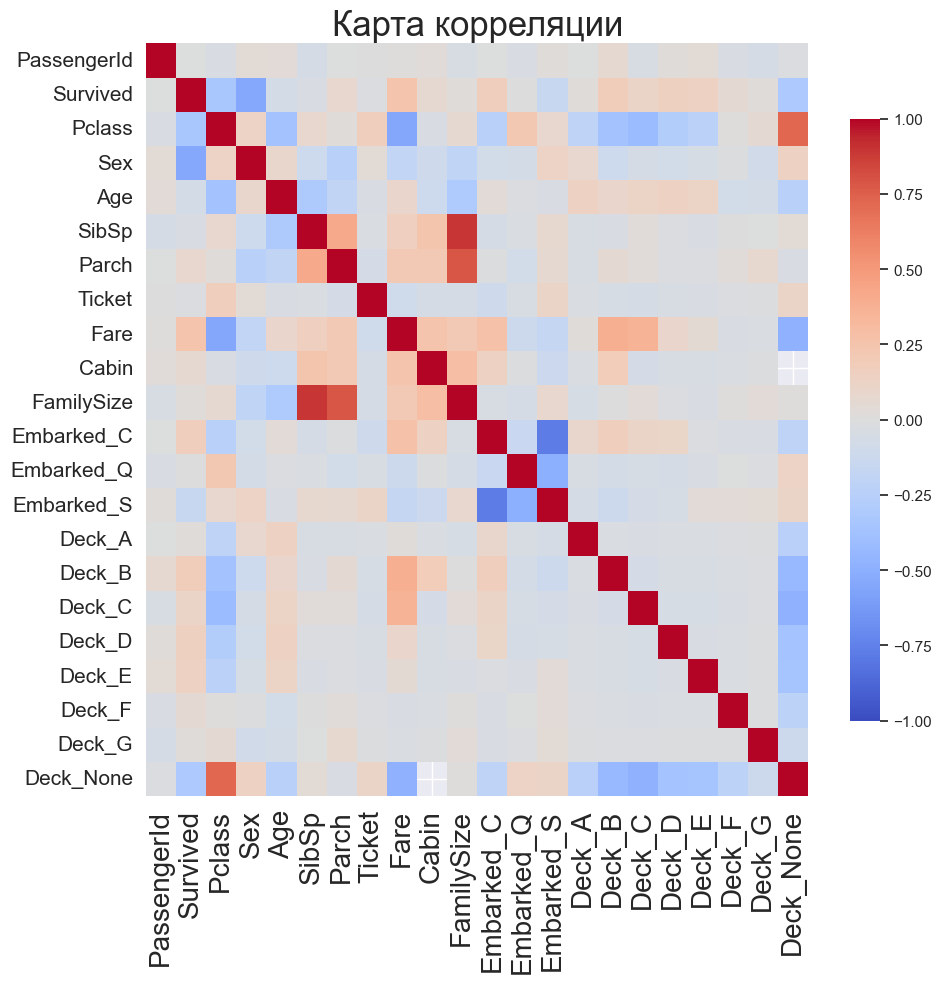

In [87]:
correlation_matrix = df_train.corr()

# Настраиваем размеры фигуры для лучшей читаемости
plt.figure(figsize=(10, 10))  # Размеры графика

sns.heatmap(
    correlation_matrix,
    annot=False,               # Не отображать числовые значения на ячейках
    cmap="coolwarm",           # Цветовая карта
    vmin=-1, vmax=1,           # Ограничения для значений корреляции
    cbar_kws={"shrink": 0.8}   # Уменьшение размера цветовой полосы
)


# Настраиваем подписи осей
plt.xticks(rotation=90, fontsize=20) 
plt.yticks(fontsize=15)               
plt.title("Карта корреляции", fontsize=25)  # Заголовок

plt.tight_layout()  # Подгонка элементов графика
plt.show()

Судя по карте корреляции, наиболее значимые признаки - пол (женщины выживают чаще), цена билета - чем выше, тем выше вероятность выживания. Также вероятность выживания выше на палубе В.

In [88]:
y_train = df_train['Survived']
del df_train['Survived']
x_train = df_train

In [89]:
y_train

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

In [90]:
x_train

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,FamilySize,...,Embarked_Q,Embarked_S,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_None
0,1,3,1,22.0,1,0,521171.0,7.2500,NaN,2,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2,1,0,38.0,1,0,17599.0,71.2833,85.0,2,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,3,3,0,26.0,0,0,23101282.0,7.9250,NaN,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,4,1,0,35.0,1,0,113803.0,53.1000,123.0,2,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,5,3,1,35.0,0,0,373450.0,8.0500,NaN,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,2,1,27.0,0,0,211536.0,13.0000,NaN,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
887,888,1,0,19.0,0,0,112053.0,30.0000,42.0,1,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
888,889,3,0,NaN,1,2,6607.0,23.4500,NaN,4,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
889,890,1,1,26.0,0,0,111369.0,30.0000,148.0,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [91]:
# Сохраняем оригинальные датафреймы для дальнейшего использования при обучении catboost
x_train_orig = x_train.copy()
y_train_orig = y_train.copy()
x_test_orig = df_test

In [93]:
y_train_orig

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

Для проверки работы модели разделим тренировочные данные на test и train.

In [94]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train,
                                                random_state=42)

In [95]:
x_train

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,FamilySize,...,Embarked_Q,Embarked_S,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_None
298,299,1,1,NaN,0,0,19988.0,30.5000,106.0,1,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
884,885,3,1,25.00,0,0,392076.0,7.0500,NaN,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
247,248,2,0,24.00,0,2,250649.0,14.5000,NaN,3,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
478,479,3,1,22.00,0,0,350060.0,7.5208,NaN,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
305,306,1,1,0.92,1,2,113781.0,151.5500,2226.0,4,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,107,3,0,21.00,0,0,343120.0,7.6500,NaN,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
270,271,1,1,NaN,0,0,113798.0,31.0000,NaN,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
860,861,3,1,41.00,2,0,350026.0,14.1083,NaN,3,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
435,436,1,0,14.00,1,2,113760.0,120.0000,9698.0,4,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [96]:
from sklearn.metrics import accuracy_score, classification_report

Создаем и обучаем модель RandomForestClassifier

In [118]:
from sklearn.model_selection import GridSearchCV
grid = {'max_depth': [10,15],"n_estimators":[100,500,1000,1500],'criterion':['gini', 'entropy', 'log_loss']}
gridsearch = GridSearchCV(RandomForestClassifier(random_state=42), grid, scoring='f1_macro', cv=3, n_jobs=-1)
gridsearch.fit(x_train, y_train)


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [10, 15],
                         'n_estimators': [100, 500, 1000, 1500]},
             scoring='f1_macro')

In [132]:
# предсказание на оригинальном датасете
y_pred_orig = gridsearch.predict(x_test_orig)

In [129]:
y_pred = gridsearch.predict(x_test)

In [131]:
# Выводим метрики
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8340807174887892
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.87       134
           1       0.83      0.73      0.78        89

    accuracy                           0.83       223
   macro avg       0.83      0.82      0.82       223
weighted avg       0.83      0.83      0.83       223



In [133]:
# Сохраняем предсказание на оригинальном датасете для загрузки в Kaggle
d_forest = {'PassengerId': x_test_orig['PassengerId'], 'Survived': y_pred_orig}
result_df_forest = pd.DataFrame(data=d_forest)
result_df_forest.to_csv('predict_forest.csv', index=False) 

In [150]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

In [155]:
x_train.columns

Index(['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'FamilySize', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G',
       'Deck_None'],
      dtype='object')

Для визуализации определим наиболее "важное" дерево (дерево с максимальной суммарной важностью признаков).

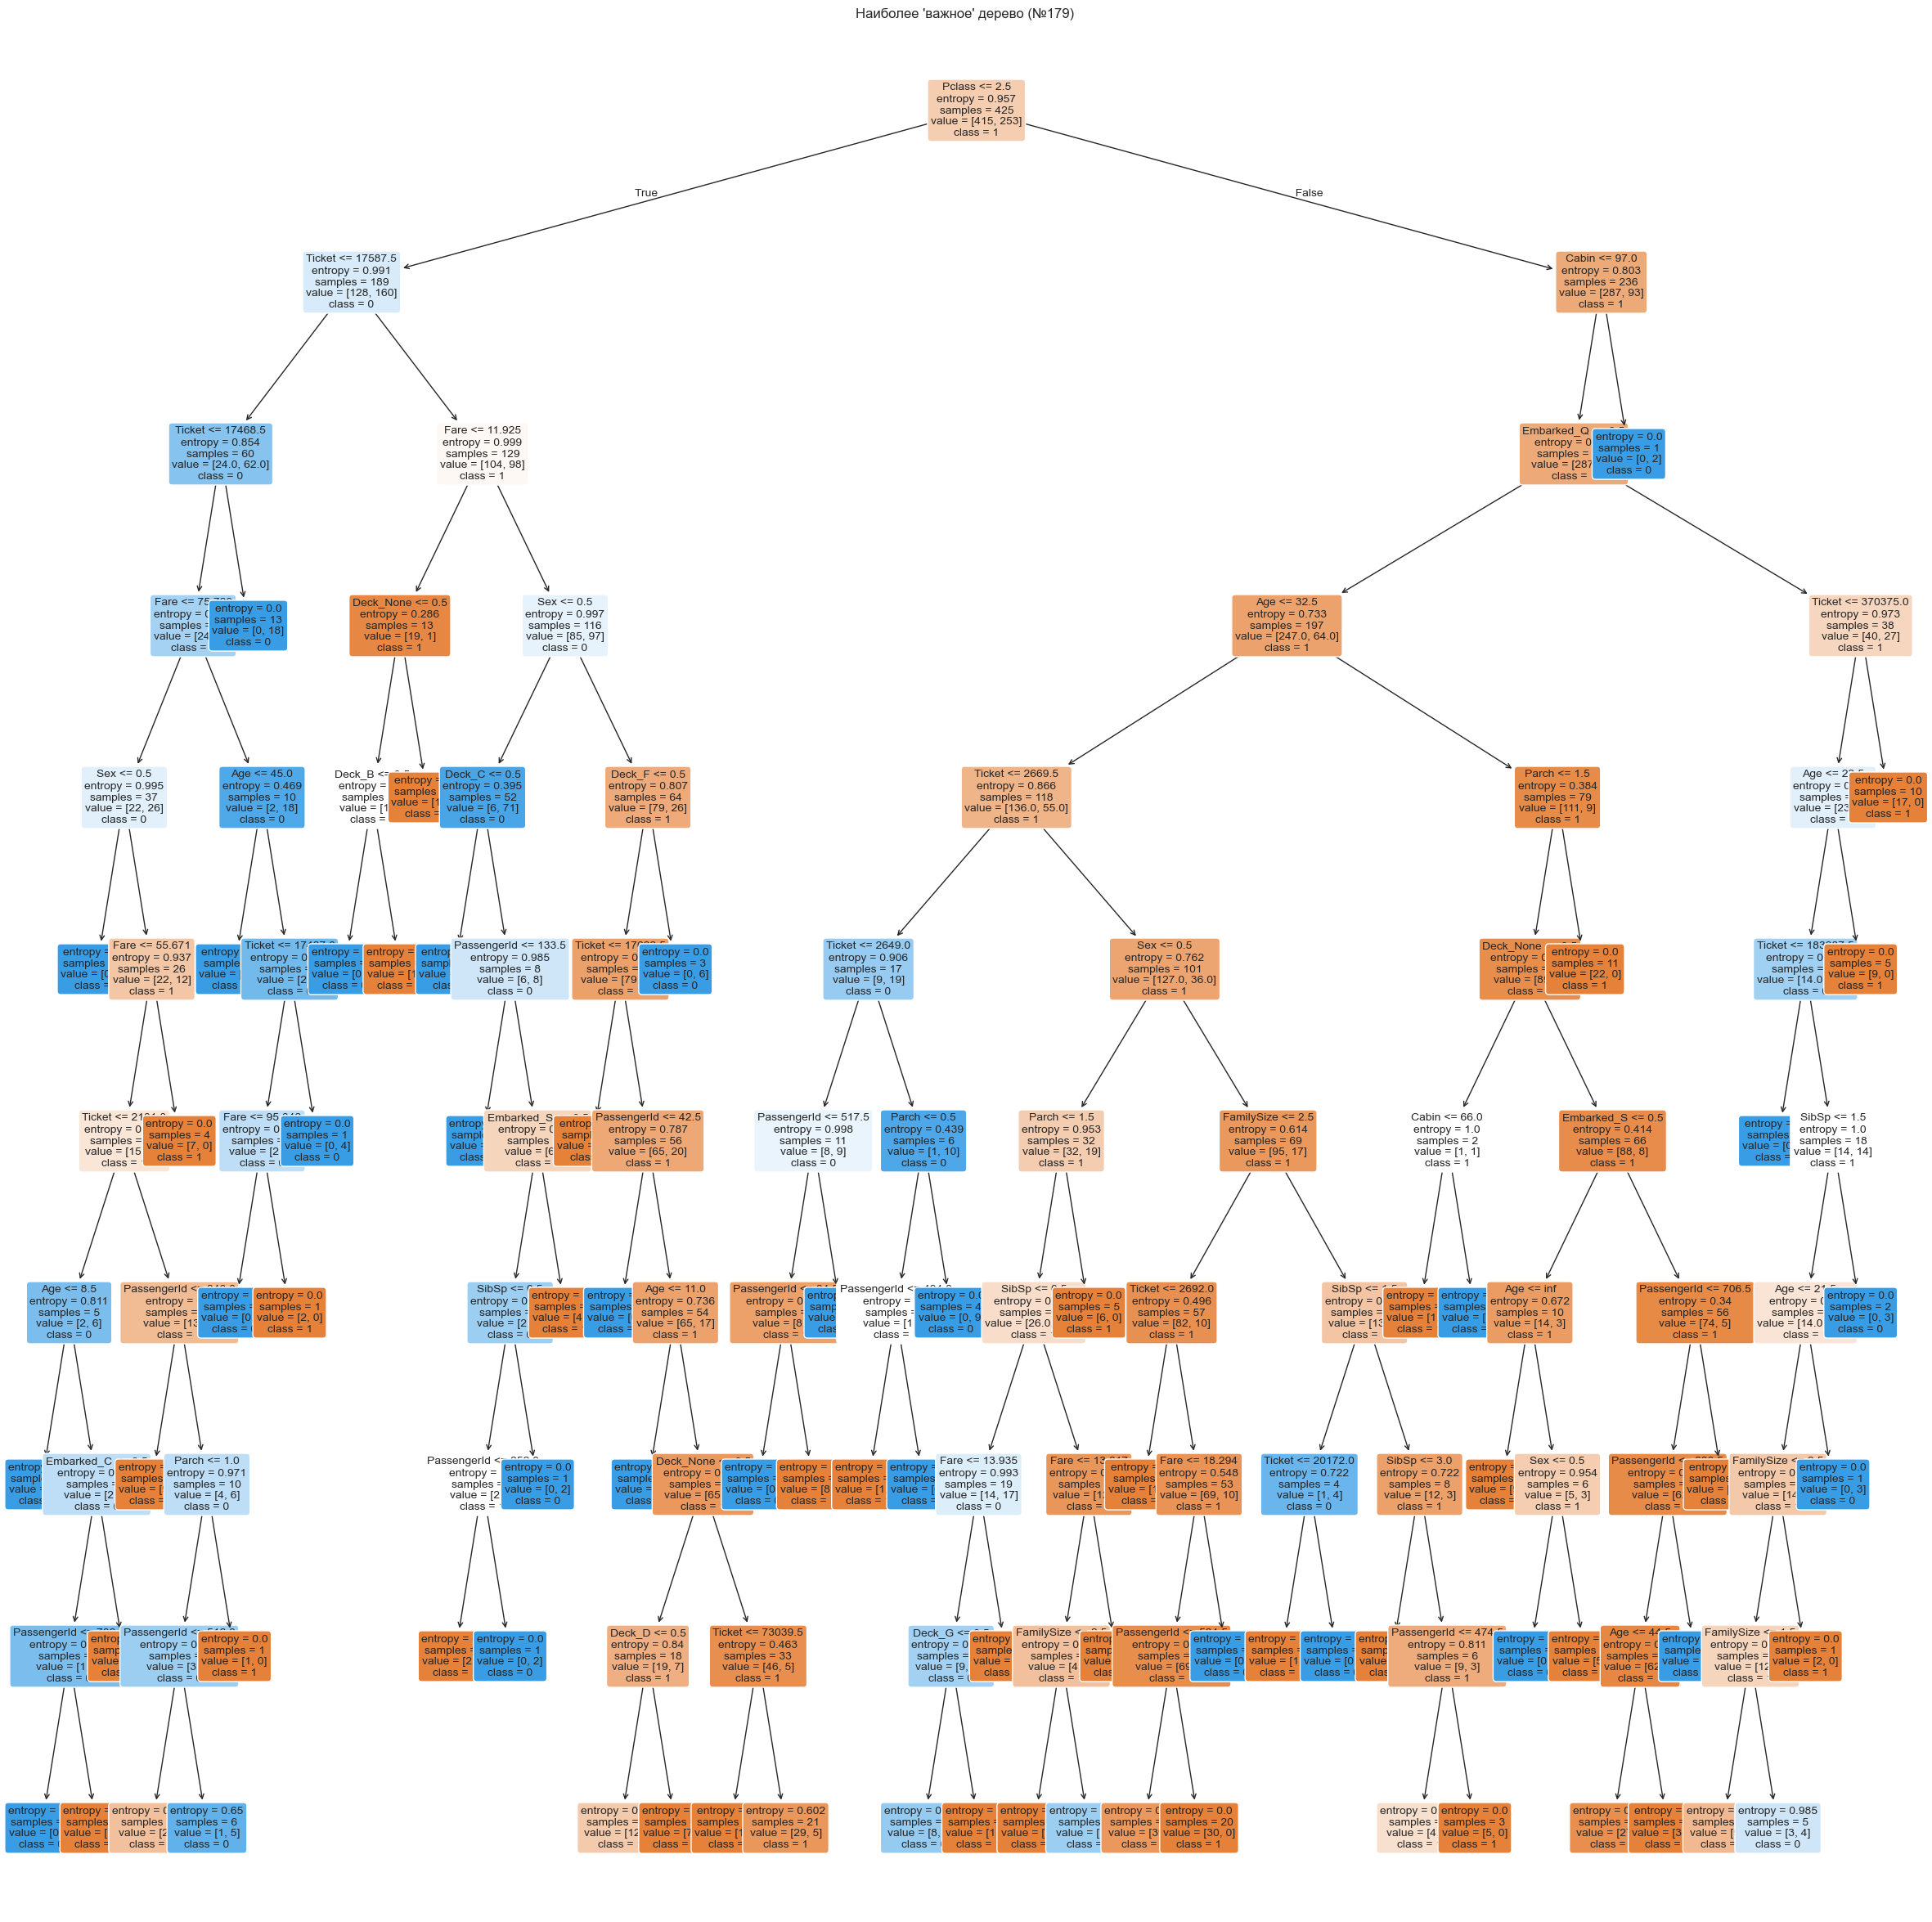

In [160]:
# Получаем имена признаков из DataFrame x_train
feature_names = x_train.columns if hasattr(x_train, "columns") else [f"Feature {i}" for i in range(x_train.shape[1])]

# Получаем классы из y_train
class_names = y_train.unique() if hasattr(y_train, "unique") else np.unique(y_train)
class_names = [str(c) for c in class_names]  # Преобразуем в строки, если нужно

# Вычисление важности признаков для каждого дерева
tree_importances = [tree.feature_importances_.sum() for tree in gridsearch.best_estimator_.estimators_]

# Найти индекс дерева с максимальной важностью признаков
most_important_tree_index = np.argmax(tree_importances)
most_important_tree = gridsearch.best_estimator_.estimators_[most_important_tree_index]

# Визуализация наиболее "важного" дерева
plt.figure(figsize=(30, 30))
plot_tree(
    most_important_tree,
    feature_names=feature_names,
    class_names=class_names,
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title(f"Наиболее 'важное' дерево (№{most_important_tree_index + 1})")
plt.show()

Результаты обученной модели с Kaggle

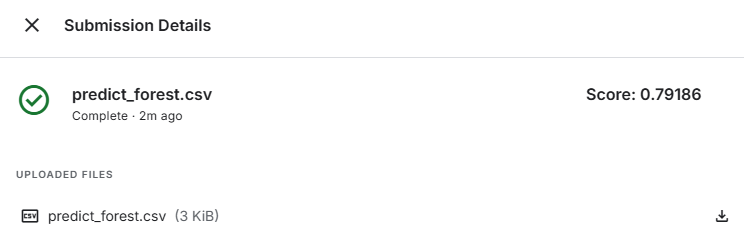

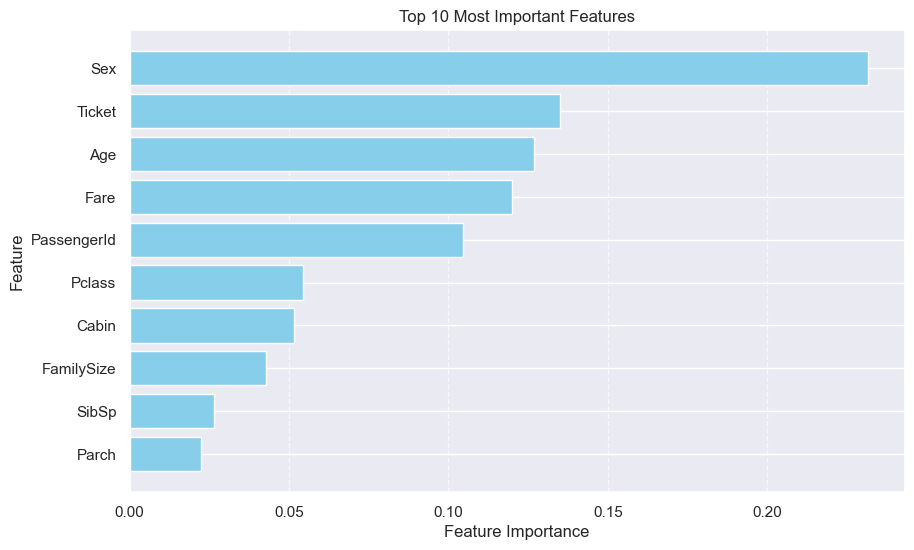

In [149]:
def plot_feature_importances(model, feature_names, top_n=10):
    """
    Строит график важности признаков для обученного RandomForestClassifier.
    
    Параметры:
        model: RandomForestClassifier
            Обученная модель RandomForestClassifier.
        feature_names: list или np.ndarray
            Имена признаков.
        top_n: int, optional (default=10)
            Количество наиболее важных признаков для отображения.
    """
    # Получаем важности признаков
    importances = model.feature_importances_
    
    # Создаем DataFrame для сортировки признаков
    feature_importances = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    
    # Берем топ-N признаков
    top_features = feature_importances.head(top_n)
    
    # Строим график
    plt.figure(figsize=(10, 6))
    plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
    plt.gca().invert_yaxis()  # Развернуть ось Y для наглядности
    plt.title('Top {} Most Important Features'.format(top_n))
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()
    
plot_feature_importances(gridsearch.best_estimator_, x_train.columns)

На диаграмме видны 10 наиболее важных признаков.

In [135]:
df_train['Survived'] = y_train

In [136]:
df_train

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,FamilySize,...,Embarked_S,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_None,Survived
0,1,3,1,22.0,1,0,521171.0,7.2500,NaN,2,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,1,0,38.0,1,0,17599.0,71.2833,85.0,2,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,3,3,0,26.0,0,0,23101282.0,7.9250,NaN,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,4,1,0,35.0,1,0,113803.0,53.1000,123.0,2,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,5,3,1,35.0,0,0,373450.0,8.0500,NaN,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,2,1,27.0,0,0,211536.0,13.0000,NaN,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
887,888,1,0,19.0,0,0,112053.0,30.0000,42.0,1,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
888,889,3,0,NaN,1,2,6607.0,23.4500,NaN,4,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
889,890,1,1,26.0,0,0,111369.0,30.0000,148.0,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN


C:\Users\LP\AppData\Local\Temp\ipykernel_44736\2763128273.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='FamilySize', y='Survived', data=df_train, ci=None, palette='Blues_d')
C:\Users\LP\AppData\Local\Temp\ipykernel_44736\2763128273.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='FamilySize', y='Survived', data=df_train, ci=None, palette='Blues_d')


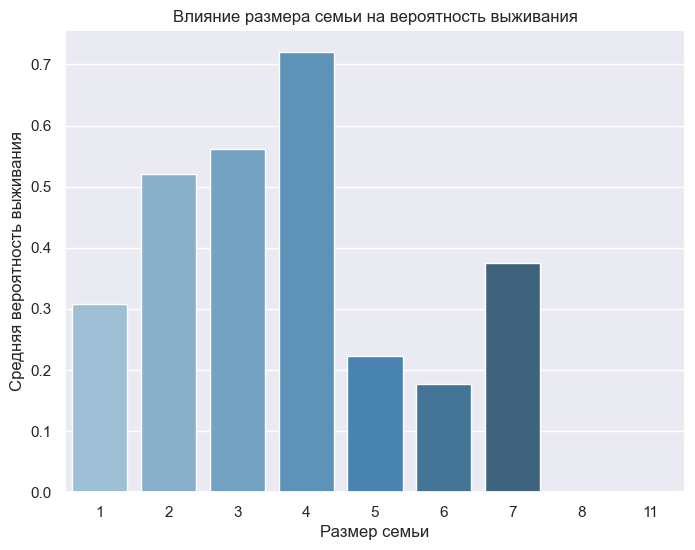

In [137]:
# График 1: Влияние размера семьи на вероятность выживания
plt.figure(figsize=(8, 6))
sns.barplot(x='FamilySize', y='Survived', data=df_train, ci=None, palette='Blues_d')
plt.title('Влияние размера семьи на вероятность выживания')
plt.xlabel('Размер семьи')
plt.ylabel('Средняя вероятность выживания')
plt.show()

Наиболее часто выживали семьи из 4 человек.

C:\Users\LP\AppData\Local\Temp\ipykernel_44736\956515577.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Sex', y='Survived', data=df_train, ci=None, palette='Set2')
C:\Users\LP\AppData\Local\Temp\ipykernel_44736\956515577.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sex', y='Survived', data=df_train, ci=None, palette='Set2')


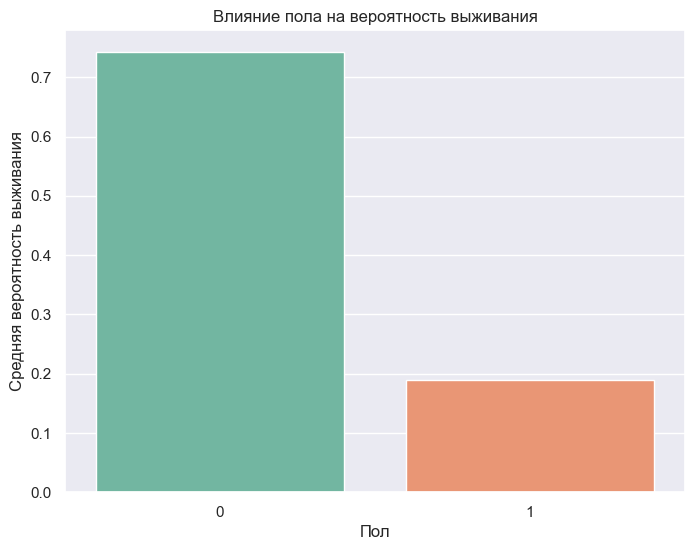

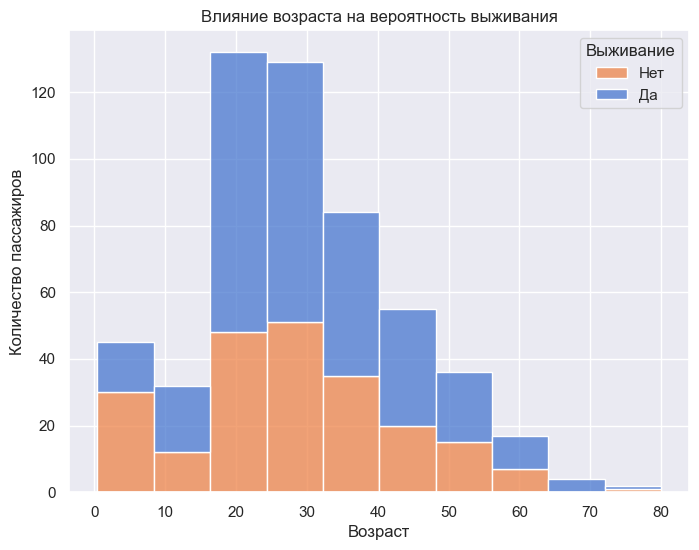

C:\Users\LP\AppData\Local\Temp\ipykernel_44736\956515577.py:20: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Deck', y='Survived', data=train, ci=None, palette='coolwarm')
C:\Users\LP\AppData\Local\Temp\ipykernel_44736\956515577.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Deck', y='Survived', data=train, ci=None, palette='coolwarm')


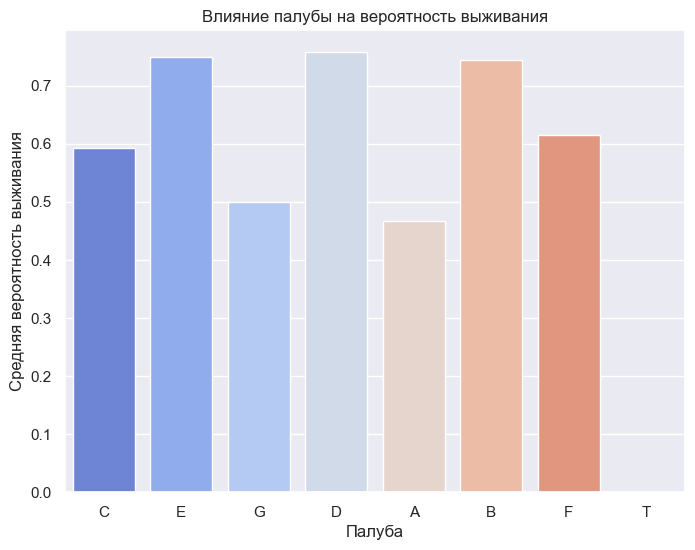

In [138]:
# График 2: Влияние пола на вероятность выживания
plt.figure(figsize=(8, 6))
sns.barplot(x='Sex', y='Survived', data=df_train, ci=None, palette='Set2')
plt.title('Влияние пола на вероятность выживания')
plt.xlabel('Пол')
plt.ylabel('Средняя вероятность выживания')
plt.show()

# График 3: Влияние возраста на вероятность выживания
plt.figure(figsize=(8, 6))
sns.histplot(data=df_train, x='Age', hue='Survived', bins=10, kde=False, palette='muted', multiple='stack')
plt.title('Влияние возраста на вероятность выживания')
plt.xlabel('Возраст')
plt.ylabel('Количество пассажиров')
plt.legend(title='Выживание', labels=['Нет', 'Да'])
plt.show()

# График 4: Влияние палубы на вероятность выживания
plt.figure(figsize=(8, 6))
sns.barplot(x='Deck', y='Survived', data=train, ci=None, palette='coolwarm')
plt.title('Влияние палубы на вероятность выживания')
plt.xlabel('Палуба')
plt.ylabel('Средняя вероятность выживания')
plt.show()

Выше вероятность выживания у женщин в возрасте 20-30 лет, палубы E, D, B,

Также обучим модель CatBoostClassifier.

In [139]:
from catboost import CatBoostClassifier, Pool
cat = CatBoostClassifier(iterations=1000)
cat.fit(x_train_orig, y_train_orig, verbose=False)

In [140]:
y_pred_cat = cat.predict(x_test_orig)

In [141]:
d_cat = {'PassengerId': x_test_orig['PassengerId'], 'Survived': y_pred_cat}
result_df_cat = pd.DataFrame(data=d_cat)
result_df_cat.to_csv('predict_cat.csv', index=False) 

Результаты обученной модели с Kaggle

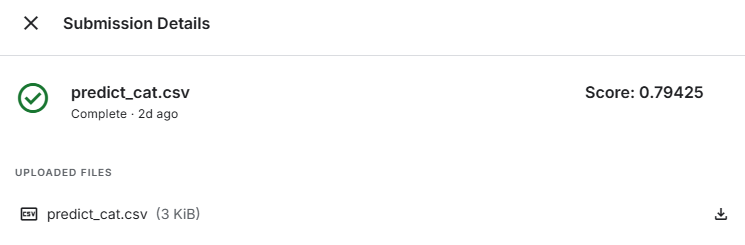

Выводы.
В ходе работы обработаны данные и обучены модели CatBoostClassifier и RandomForestClassifier.

Эффективность моделей судя по метрике Score от Kaggle приблизительно одинакова (0,79).

Наиболее часто выживают семьи из 4 человек.
Выше вероятность выживания у женщин в возрасте 20-30 лет, палубы E, D, B.